In [8]:
%load_ext autoreload
%autoreload 2

from typing import List
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, auc, accuracy_score, balanced_accuracy_score

from hnlp_proj.loader import load_ynet, load_eng_test
from hnlp_proj.processing import Processing, process_data
from hnlp_proj.utils import extract_authors, flip_hebrew_text, combine_texts, clean_texts
from hnlp_proj.plot_utils import plot_hebrew_barchart, plot_corpus_sizes, plot_feature_freqs
from hnlp_proj.delta import DeltaTransformer, combine_texts_by_author


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
texts = load_ynet(show_html_len_plot=False)
#texts = load_eng_test()


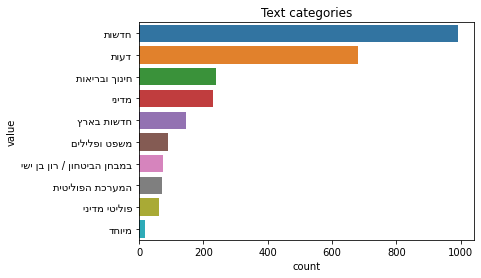

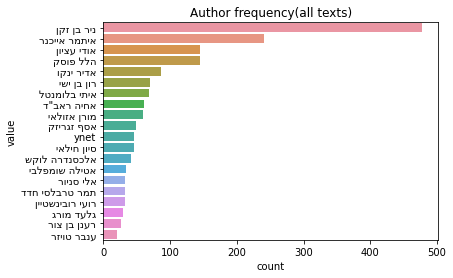

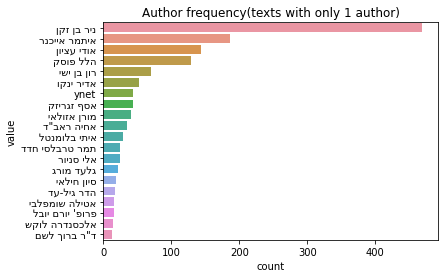

In [74]:
# Plotting frequency of categories
if "category" in texts.columns:
    plot_hebrew_barchart(texts.category, 20, title="Text categories")

# Plotting author frequency of texts
NUM_AUTHORS = 20
texts.authors = texts.authors.apply(extract_authors)
plot_hebrew_barchart(texts.authors, NUM_AUTHORS, title="Author frequency(all texts)")

# find all texts that only have 1 author
one_author_df = texts[texts.authors.str.len() == 1].copy()
one_author_df["authors"]  = one_author_df["authors"].apply(lambda ls: ls[0])
one_author_df.rename(columns={"authors": "author"}, inplace=True)

if len(one_author_df) != len(texts):
    plot_hebrew_barchart(one_author_df.author, NUM_AUTHORS, title="Author frequency(texts with only 1 author)")

In [5]:
print(f"Out of {len(texts)} articles, {len(one_author_df)} of them were written by exactly 1 author")

Out of 2607 articles, 1900 of them were written by exactly 1 author


In [6]:
# find texts with no author(Faulty parsing?)
no_author_df = texts[texts.authors.str.len() == 0]
no_author_df

,fmt,url,main_title,sub_title,authors,date,text,category
14,2021,https://www.ynet.co.il/news/article/SkvJP7fH00,"בלי להודיע: ארה""ב העבירה לפחות 75 מיליון דולר ...","על פי דיווח בסוכנות הידיעות AP, ממשל ביידן איש...",[],"31.03.21 , 20:57",ארצות הברית אישרה בימים האחרונים העברת עשרות מ...,מדיני
28,2021,https://www.ynet.co.il/news/article/SyorLaZO00,"אופטימיות בגוש השינוי, סיכומים ראשונים על חלוק...",בסיומו של היום הראשון למנדט של לפיד נרשמת שביע...,[],"07.05.21 , 00:27",בקרב השותפים הפוטנציאליים לממשלת השינוי נרשמה ...,המערכת הפוליטית
57,2021,https://www.ynet.co.il/news/article/r1sjt9J00u,גורמים בימין: נתניהו והרב טאו סיכמו להגביל עלי...,"הבוקר ב""ידיעות אחרונות"": עד לאחרונה התנגד נחרצ...",[],"05.05.21 , 07:15",גורמים בקרב פעילי הר הבית טוענים כי של לאשר ממ...,המערכת הפוליטית
89,2021,https://www.ynet.co.il/news/article/Bk5VPxfNd,דיווח: ראש המוסד התערב להסרת המגבלות על מיליאר...,יוסי כהן והשגריר לשעבר דרמר שכנעו את ממשל טראמ...,[],"19.03.21 , 12:42","למהלך השנוי במחלוקת והחשאי ל , בשלהי ימי ממשל ...",מדיני
92,2021,https://www.ynet.co.il/news/article/BkK1s1Z400,"אזהרה ישראלית בביקור בצרפת: ""לא נהסס לתקוף בעו...","הרמטכ""ל כוכבי אמר כי ""לבנון הפכה שבויה בידי חי...",[],"18.03.21 , 18:02","נשיא המדינה , שמבקר בפריז שבצרפת עם הרמטכ""ל , ...",מדיני
...,...,...,...,...,...,...,...,...
2602,2021,https://www.ynet.co.il/news/article/BkhnD9QGd,לא לשפוך את התינוק עם המים של טראמפ,"ביידן מתרחק מכל מה שקשור בנשיא הקודם, כולל המד...",[],"24.02.21 , 12:00",קולו של חבר הקונגרס הדמוקרטי ג’יימי רסקין נשבר...,דעות
2603,2021,https://www.ynet.co.il/news/article/BktSK5mz00,הפגם לא מתחיל בתיקי נתניהו ולא נגמר שם,"משפטני-על, שמצופה מהם שדבר לא ייפול מידיהם, לא...",[],"24.02.21 , 12:01","""נפל פגם"", במשפטו של ראש הממשלה בנימין נתניהו....",דעות
2604,2021,https://www.ynet.co.il/news/article/rymTSuQMd,אתם לא בוחרים שלטון. אתם אוהדי כדורגל,"בחירה פוליטית היא חלק מהזהות, כמו סגנון לבוש א...",[],"24.02.21 , 08:51","תארו לעצמכם שביום הבחירות הגעתם לקלפי, הצגתם א...",דעות
2605,2021,https://www.ynet.co.il/news/article/S1kZ2FMM00,מתווה ההשתקה שעקף את משפחות ילדי תימן,"ה""הסכם"" לפיצוי משפחות ילדי תימן, מזרח והבלקן פ...",[],"23.02.21 , 16:14","לפני ארבע שנים בדיוק זכיתי לתעד את מפתח תקווה,...",דעות


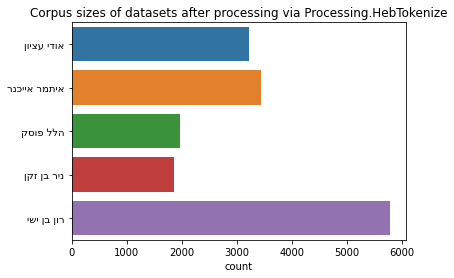

combine by author


,",",.,של,את,"""",על,עם,לא,-,גם,...,כי,ישראל,או,יש,אבל,:,היא,בין,הרכב,כל
author,,,,,,,,,,,,,,,,,,,,,
אודי עציון,226,139,50,45,37,30,18,19,18,30,...,11,2,13,11,14,12,10,9,22,8
איתמר אייכנר,186,146,72,61,66,63,34,37,8,25,...,18,20,14,13,18,7,5,9,0,13
הלל פוסק,96,83,28,15,15,21,19,5,21,6,...,18,1,6,7,3,8,6,7,15,5
ניר בן זקן,90,78,19,21,30,11,26,9,22,14,...,9,0,4,5,5,15,3,4,2,1
רון בן ישי,280,248,114,100,57,56,41,47,43,36,...,6,38,21,20,12,10,18,12,0,12


In [77]:


RANDOM_STATE = 0
NUM_AUTHORS = 5
NUM_FEATURES = 25
MAX_TEXTS_PER_AUTHOR = 5
PROCESSING = Processing.HebTokenize

# choose some of the most prolific authors
most_prolific_authors = one_author_df.author.value_counts()[:NUM_AUTHORS].index
used_texts = one_author_df.set_index("author").loc[most_prolific_authors].reset_index()
used_texts = used_texts.groupby("author").head(MAX_TEXTS_PER_AUTHOR)

plot_corpus_sizes(combine_texts_by_author(process_data(used_texts, PROCESSING)), f"Corpus sizes of datasets after processing via {PROCESSING}")

# choose features
pipeline = make_pipeline(DeltaTransformer(num_features=NUM_FEATURES, processing=PROCESSING))
X = pipeline.fit_transform(used_texts, used_texts.index)
features = pipeline.steps[0][1].get_params()["features"]
#plot_feature_freqs(pipeline.steps[0][1].last_transformed_count, features, "Chosen features and frequencies")
pipeline.steps[0][1].last_transformed_count

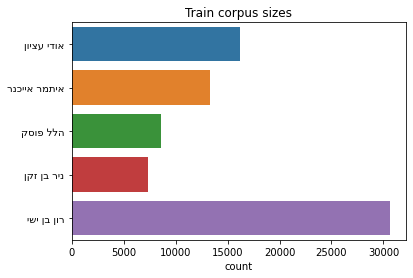

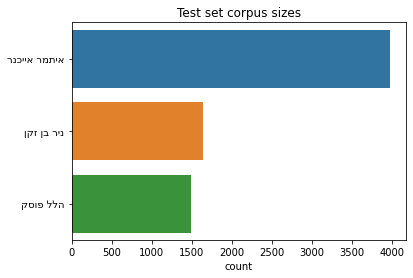

NameError: name 'create_feature_matrix' is not defined

In [39]:
# split one-author dataset to train and test
X_train, X_test = train_test_split(used_texts, random_state=RANDOM_STATE,
 test_size=0.1)

plot_corpus_sizes(combine_texts_by_author(X_train), title="Train corpus sizes")
plot_corpus_sizes(X_test.set_index("author"), "Test set corpus sizes")


X_train = create_feature_matrix(X_train, features=features)
X_test = create_feature_matrix(X_test, features=features, combine_by_author=False)
#X_train.dropna(inplace=True)
y_train = X_train.index
y_test = X_test.index


knn = KNeighborsClassifier(n_neighbors=1, metric="manhattan")
knn.fit(X_train, y_train)


y_pred = knn.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred, labels=most_prolific_authors, average='weighted')}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}")
knn.score(X_test, y_test)

In [30]:
X

,",",.,של,את,"""",על,עם,לא,-,גם,...,כי,ישראל,או,יש,אבל,:,היא,בין,הרכב,כל
author,,,,,,,,,,,,,,,,,,,,,
ניר בן זקן,0.105707,0.016054,-0.399439,-1.261714,-0.600917,-0.752814,2.364886,1.318200,-0.935142,0.627386,...,-0.508687,-0.771331,-0.057237,0.727667,1.312365,2.105864,-1.037671,-0.056744,-0.144567,-0.927260
ניר בן זקן,-0.008775,0.085508,-1.466402,-0.091569,1.141022,-0.958115,0.723307,0.083614,2.744510,0.902621,...,-0.026146,-0.771331,0.299119,-0.550576,0.636422,1.545963,-0.196232,-0.324212,-0.609385,-0.141163
ניר בן זקן,-0.957124,-0.499291,-0.004101,0.057150,0.355026,-1.064885,-0.124546,0.085983,-0.540159,0.663528,...,-0.500833,-0.771331,-1.066285,-0.222009,0.284887,1.550463,-1.037671,-0.883742,-0.136777,-0.927260
ניר בן זקן,1.290299,-0.269379,-0.535143,-0.140255,-0.259000,0.446220,0.084873,-1.188242,-0.935142,0.962834,...,1.188701,-0.771331,-1.066285,-1.204061,-0.777620,-0.870685,0.399453,1.027542,-0.609385,-0.927260
ניר בן זקן,-1.041970,-0.495066,-1.730198,-0.455067,0.442753,-0.976456,1.598836,-1.188242,2.587372,-1.529065,...,-0.977291,-0.771331,0.240810,0.047094,-0.777620,-0.870685,0.573340,-0.883742,-0.609385,-0.927260
איתמר אייכנר,-0.217848,0.142247,0.308673,0.012536,-0.602830,0.666980,-1.658666,0.683875,-0.935142,-1.171131,...,0.889433,0.150077,1.445983,-1.204061,-0.257268,-0.870685,0.200890,-0.471940,-0.609385,0.229841
איתמר אייכנר,1.239354,-1.223272,0.689808,0.480291,0.577005,0.726523,0.903154,2.371768,-0.402404,1.287398,...,-0.793683,1.947517,0.712855,1.066603,2.702688,-0.637431,-0.306733,0.088359,-0.609385,1.348953
איתמר אייכנר,-1.714919,1.785269,-1.315015,2.076168,4.075714,-0.609613,-0.425860,0.347692,-0.935142,-0.648091,...,-0.402975,0.362590,-1.066285,-1.204061,-0.777620,2.777342,-1.037671,-0.883742,-0.609385,0.496714
איתמר אייכנר,-2.031743,3.120379,2.269270,0.920472,-1.067167,2.557345,1.020431,-1.188242,-0.935142,-1.529065,...,-0.145233,-0.771331,-1.066285,0.510937,-0.777620,-0.870685,-1.037671,0.584683,-0.609385,-0.927260
